In [1]:
import os
from importlib import reload

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import utilities

Features to add:
- add item_category, shop_id, and item_id as features
- encode these categorical vars: mean encode - HOW?
    - most successfull one in the homework was expanding mean scheme. - suggests I need lagged features too

- create a feature that bins shops into groups based on net income
    - perhaps net income by category of item
- create feature that bins shops into groups based on seasonal pattern (spectral biclustering?)
- similarly create a feature that groups products based on seasonal pattern
- need to add date indicators:
    * perhaps group months into high holiday/low holiday count
    * perhaps number of days in month
    * number of weekend days vs week days
- create features based on lagged behavior
    * rolling windows sum/variance (last 3 mos, last 6 months, last year)
    * can do this for each item, or can use this as an encoding of shop, and category ids


In [35]:
sales = utilities.load_and_preprocess()
agg_sales = utilities.aggregate_monthly(sales)
piv_agg_sales = agg_sales.set_index(['Month', 'shop_id', 'item_id']).item_cnt_month.unstack(level=0).fillna(0)

In [36]:
piv_agg_sales

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     31.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154        1.0      0.0      0.0      0.0      0.0      0.0   
        22155        0.0      0.0      0.0      0.0      0.0      0.0   
        22162        0.0      0.0      0.0      0.0      0.0      0.0   
        22164        0.0      0.0      0.0      0.0      0.0      0.0   
        22167        0.0      0.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   
...                  ...      ...      ...      ...  ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0  ...      0.0      0.0   
        22155        1.0      0.0      0.0      0.0  ...      0.0      0.0   
        22162        0.0      0.0      0.0      0.0  ...      0.0      9.0   
        22164        0.0      0.0      0.0      0.0  ...      0.0      2.0   
        22167        0.0      0.0      0.0      1.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154        0.0      0.0      0.0      0.0      0.0      0.0   
        22155        0.0      0.0      0.0      0.0      0.0      0.0   
        22162        4.0      1.0      1.0      0.0      0.0      1.0   
        22164        1.0      2.0      0.0      0.0      1.0      0.0   
        22167        0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  
...                  ...      ...  
59      22154        0.0      0.0  
        22155        0.0      0.0  
        22162        0.0      0.0  
        22164        0.0      0.0  
        22167        0.0      0.0  

[424124 rows x 34 columns]

In [37]:
%%time
half_lifes = [3,6,9,12]
sales_ewms = {tau:piv_agg_sales.ewm(halflife=6, axis=1).mean() for tau in half_lifes}

Wall time: 9 s


In [39]:
piv_agg_sales.groupby(level=0).transform('sum')

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30        5578.0   6127.0      0.0      0.0      0.0      0.0   
        31        5578.0   6127.0      0.0      0.0      0.0      0.0   
        32        5578.0   6127.0      0.0      0.0      0.0      0.0   
        33        5578.0   6127.0      0.0      0.0      0.0      0.0   
        35        5578.0   6127.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154     2017.0   1897.0   2028.0   1388.0   1374.0   1707.0   
        22155     2017.0   1897.0   2028.0   1388.0   1374.0   1707.0   
        22162     2017.0   1897.0   2028.0   1388.0   1374.0   1707.0   
        22164     2017.0   1897.0   2028.0   1388.0   1374.0   1707.0   
        22167     2017.0   1897.0   2028.0   1388.0   1374.0   1707.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   
...                  ...      ...      ...      ...  ...      ...      ...   
59      22154     1747.0   2048.0   2008.0   1751.0  ...   1293.0   1206.0   
        22155     1747.0   2048.0   2008.0   1751.0  ...   1293.0   1206.0   
        22162     1747.0   2048.0   2008.0   1751.0  ...   1293.0   1206.0   
        22164     1747.0   2048.0   2008.0   1751.0  ...   1293.0   1206.0   
        22167     1747.0   2048.0   2008.0   1751.0  ...   1293.0   1206.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   
...                  ...      ...      ...      ...      ...      ...   
59      22154     1199.0   1054.0    916.0    913.0    992.0   1214.0   
        22155     1199.0   1054.0    916.0    913.0    992.0   1214.0   
        22162     1199.0   1054.0    916.0    913.0    992.0   1214.0   
        22164     1199.0   1054.0    916.0    913.0    992.0   1214.0   
        22167     1199.0   1054.0    916.0    913.0    992.0   1214.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  
...                  ...      ...  
59      22154      914.0    790.0  
        22155      914.0    790.0  
        22162      914.0    790.0  
        22164      914.0    790.0  
        22167      914.0    790.0  

[424124 rows x 34 columns]

In [ ]:
def get_single_month_XY(month_, fill_value=None):
    
    return df

In [ ]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    fitted_model = model.fit(x_train, y_train)
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model(x_val)
    else:
        y_val_pred = None
    
    return fitted_model, y_train_pred, y_val_pred
    

In [ ]:
def rolling_cross_validation(model, num_stack_months):
    fitted_models = {}
    scores = {}
    
return fitted_models, scores

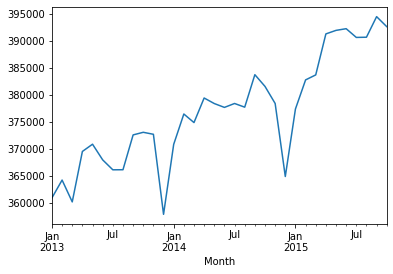

In [6]:
piv_agg_sales.isnull().sum().plot()

In [7]:
temp = piv_agg_sales.drop_duplicates()

In [8]:
temp.shape

(155714, 34)

In [11]:
piv_agg_sales.shape

(424124, 34)

In [12]:
temp = piv_agg_sales.T.drop_duplicates()

In [13]:
temp.shape

(34, 424124)

In [18]:
reduced_df = piv_agg_sales.iloc[:20000].reset_index(drop=True)

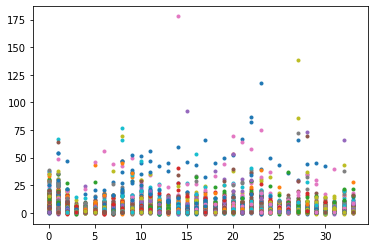

In [22]:
plt.plot(reduced_df.T.reset_index(drop=True), '.')
plt.show()

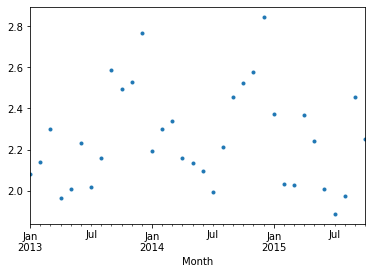

In [28]:
piv_agg_sales.mean().plot(style='.')

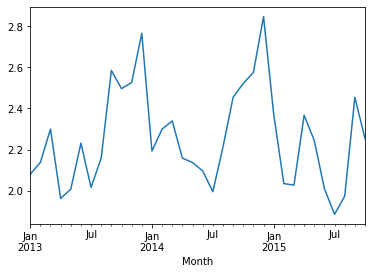

In [30]:
piv_agg_sales.mean().plot()

In [35]:
shop_agg = piv_agg_sales.groupby(level=0).sum()

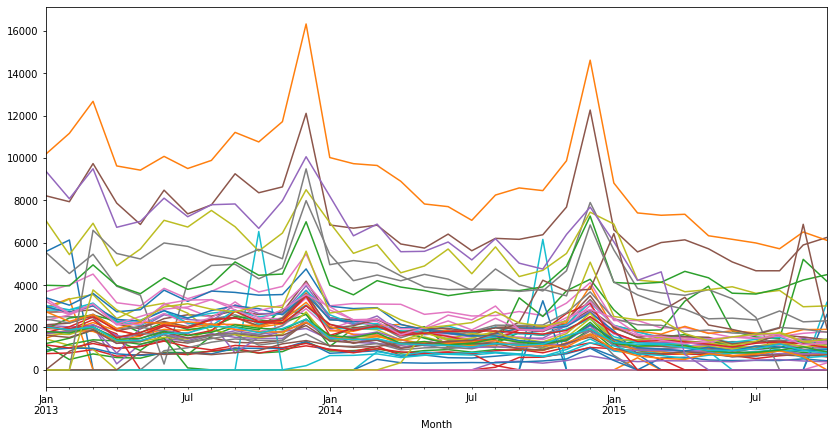

In [42]:
shop_agg.T.plot(legend=False, figsize=(14,7))


In [49]:
shop_agg_corr = shop_agg.T.corr()

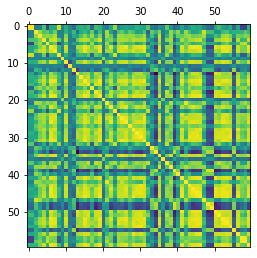

In [50]:
plt.matshow(shop_agg_corr)

In [51]:
from sklearn.cluster import SpectralBiclustering

In [128]:
model = SpectralBiclustering(n_clusters=4, method='log', random_state=42)

In [129]:
model.fit(shop_agg_corr)

SpectralBiclustering(method='log', n_clusters=4, random_state=42)

In [130]:
fit_data = shop_agg_corr.iloc[np.argsort(model.row_labels_)]

In [131]:
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

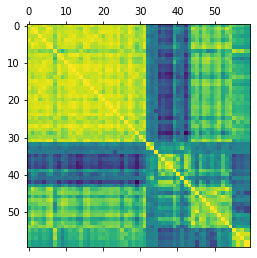

In [132]:
plt.matshow(fit_data)

In [134]:
import seaborn as sns

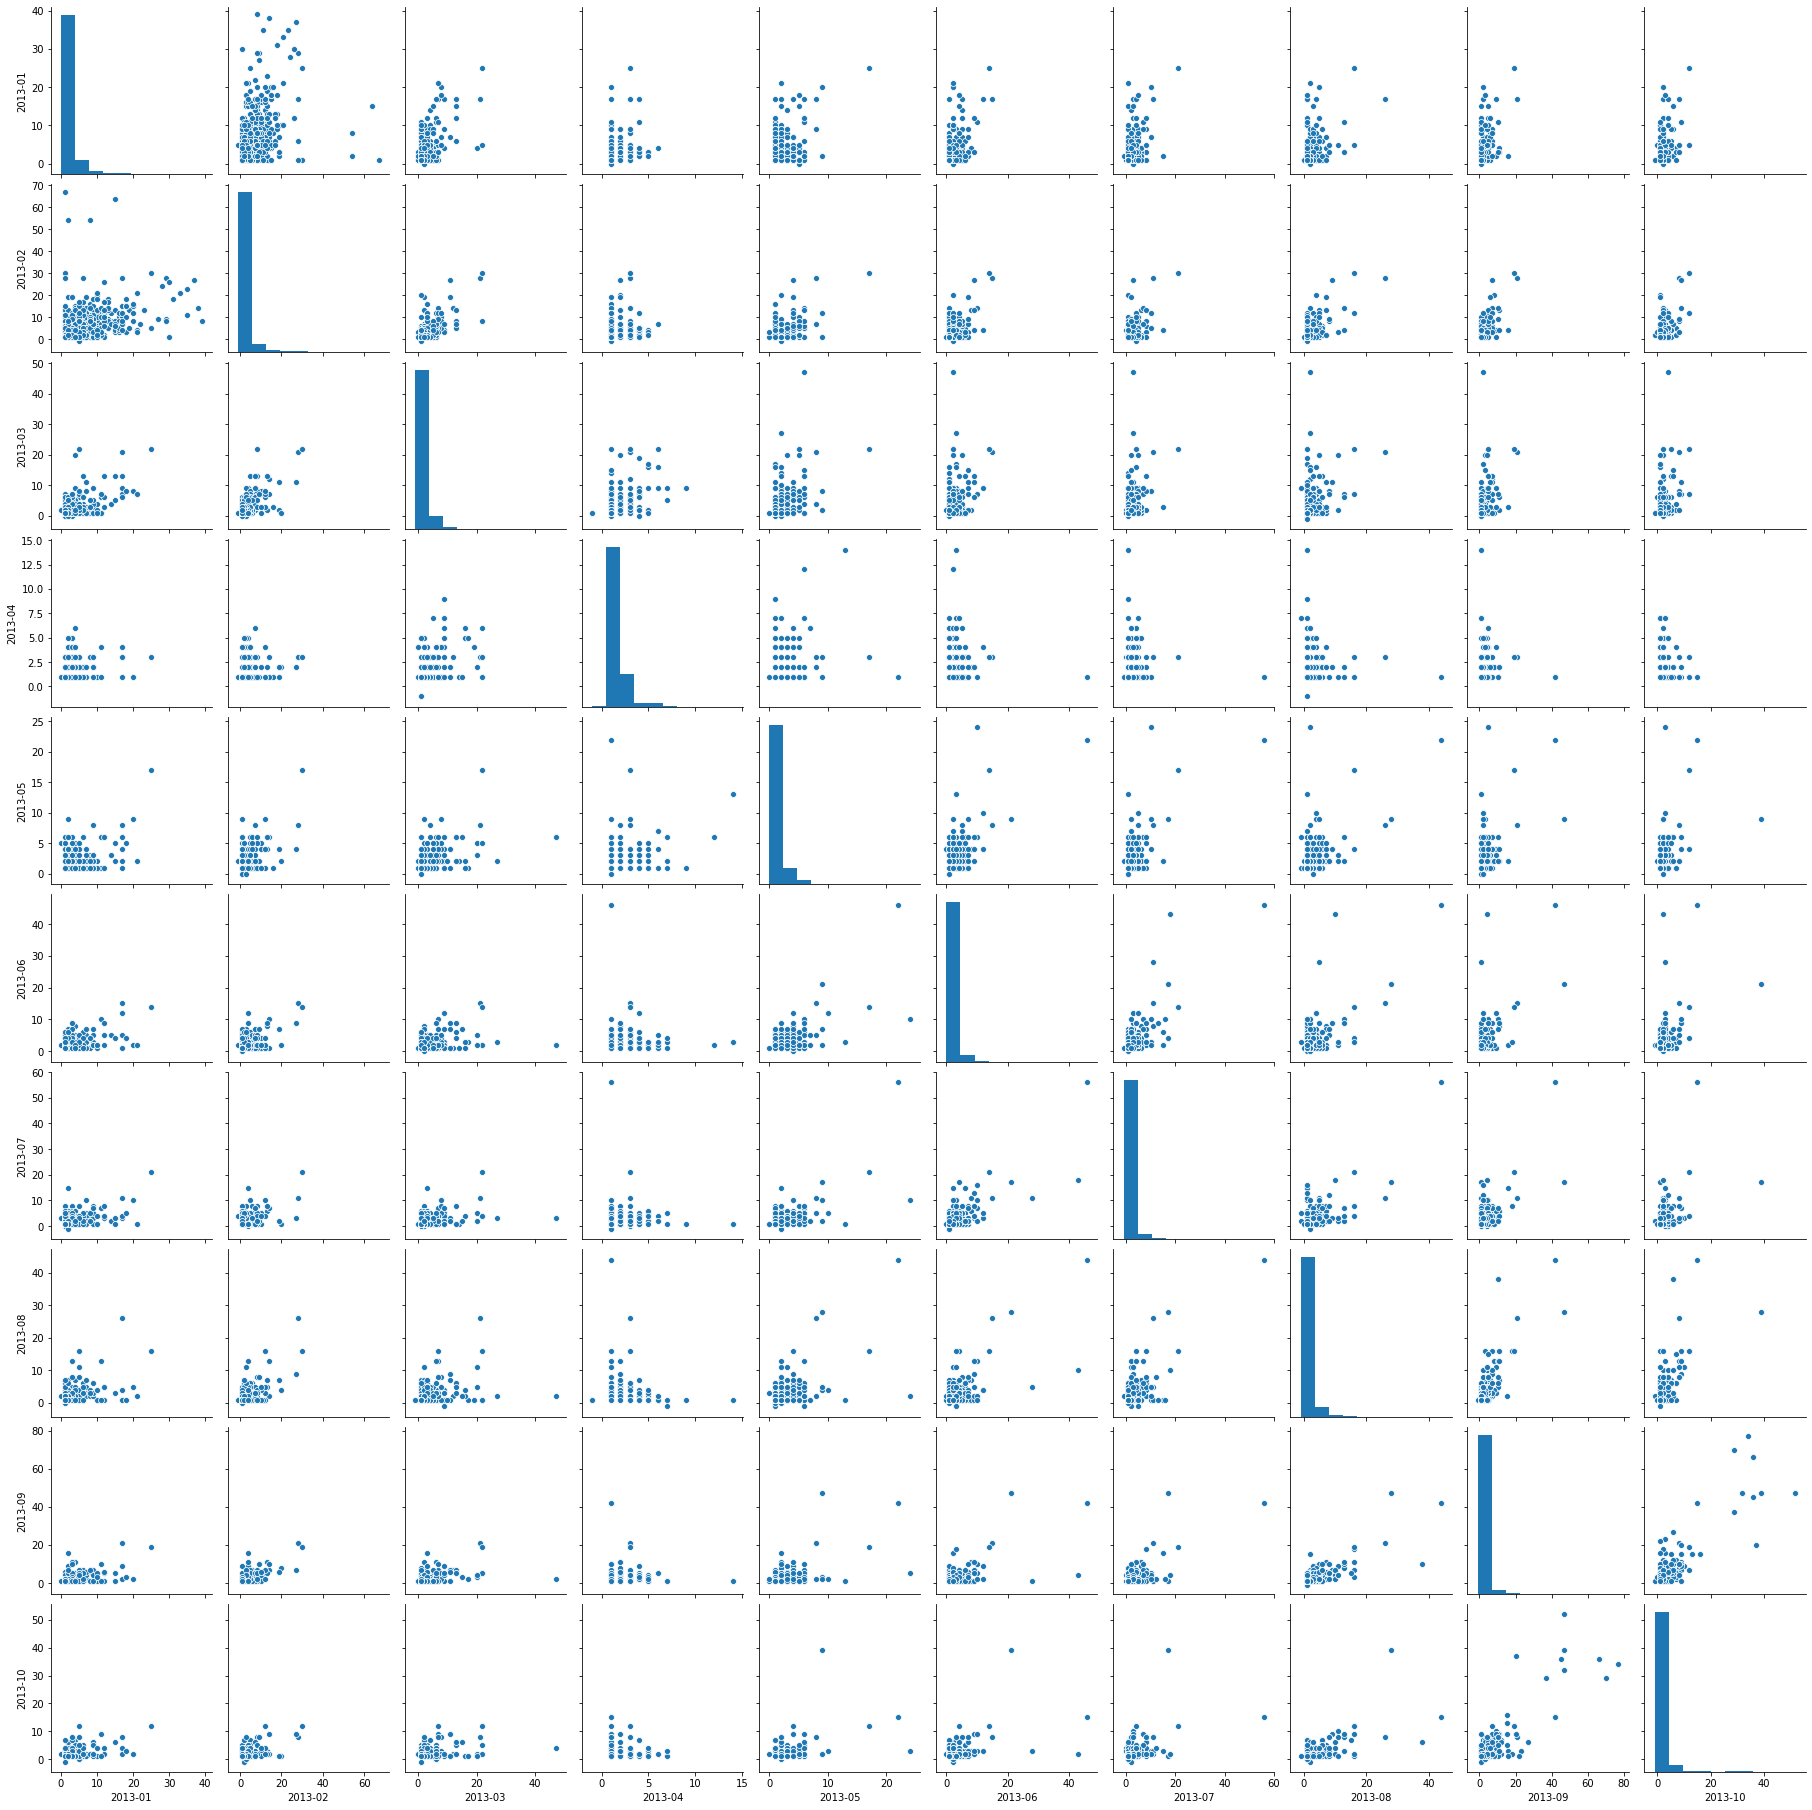

In [136]:
sns.pairplot(reduced_df.iloc[:,:10])

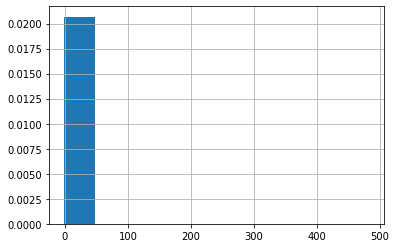

In [26]:
piv_agg_sales.iloc[:,30].hist(density=True)

In [9]:
corrmat = piv_agg_sales.corr()

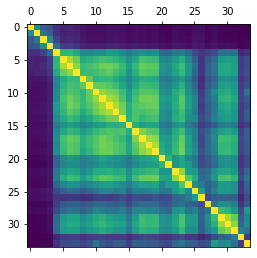

In [10]:
plt.matshow(corrmat)

In [ ]:
def add_pred_month